<div style="text-align:center; font-size:26px; color:green;">Estrategia con medias móviles exponenciales (EMA's)</div>

Si no compartes el conocimiento no sirve para nada. [Michio Kaku](https://www.youtube.com/watch?v=6rDxlolYUQw)



# Lógica y definición de la estrategia.
<u>Método `def detect_entry_exit_points(self)`:</u> 

Esta estrategia utiliza dos medias móviles exponenciales (EMA) de diferentes ventanas de tiempo para generar señales de compra y venta en función de sus intersecciones. La lógica detrás de la estrategia se basa en el cruce de la EMA corta sobre la EMA larga como señal de compra, y el cruce de la EMA corta por debajo de la EMA larga como señal de venta.

La definición de la estrategia implica los siguientes pasos:

* Se calculan las medias móviles exponenciales corta y larga utilizando las ventanas de tiempo especificadas.
* Se unen los valores de cierre (Close) del activo con las medias móviles exponenciales calculadas.
* Se crea un DataFrame para almacenar las fechas de entrada y salida, así como los precios de cierre correspondientes.
* Se itera sobre los datos para detectar los puntos de entrada y salida:  
      Cuando la EMA corta cruza por encima de la EMA larga, se marca como una señal de compra.  
      Cuando la EMA corta cruza por debajo de la EMA larga, se marca como una señal de venta.  
* Se eliminan las filas con valores nulos (NaN) en el DataFrame de fechas de entrada y salida.
* Se devuelve el DataFrame con las fechas de entrada y salida marcadas.


<u>Método `def calculate_invest_evolution(self, entry_exit_dates)`:

Este método calcula la evolución de una inversión basada en los puntos de entrada y salida proporcionados en el DataFrame entry_exit_dates. La lógica detrás de la estrategia implica el seguimiento de los precios de cierre (Close) y la generación de señales de compra y venta para calcular el rendimiento de la inversión a lo largo del tiempo.

La definición de la estrategia se realiza de la siguiente manera:

* Se verifica si hay datos en el DataFrame de entrada y salida. Si está vacío, se devuelve el DataFrame vacío.  
* Se crea una copia del DataFrame de entrada y salida para calcular la evolución de la inversión.  
* Se calcula el rendimiento de la estrategia de "Comprar y Mantener" (Buy & Hold) en función del precio de cierre inicial.  
* Se inicializan las variables de efectivo (cash) y acciones (shares) con un valor de 100.
* Se itera sobre las filas del DataFrame de entrada y salida para simular la inversión:  
        Cuando se detecta una señal de compra (Entry_Exit igual a 1), se calcula el número de acciones que se pueden comprar con el efectivo disponible y se actualiza el saldo de efectivo a cero.  
        Cuando se detecta una señal de venta (Entry_Exit igual a -1), se calcula el efectivo generado por la venta de todas las acciones y se actualiza el saldo de acciones a cero.  
* Se calcula el valor total de la inversión (Buy&Sell) en cada paso.
* Se calcula el valor total de la inversión (Buy&Hold) en cada paso.
* Se devuelve el DataFrame con la evolución de la inversión.

# Bibliotecas Utilizadas

En este proyecto, utilizamos las siguientes bibliotecas de terceros:

- [yfinance](https://github.com/ranaroussi/yfinance): Una biblioteca de Python que proporciona una interfaz para acceder a los datos de Yahoo Finance.
- [Matplotlib](https://matplotlib.org/): Una biblioteca de trazado en 2D de Python que produce figuras de calidad de publicación en una variedad de formatos impresos y entornos interactivos a través de interfaces de usuario.
- [Plotly](https://plotly.com/python/): Una biblioteca de gráficos interactivos para Python que ofrece una variedad de opciones de visualización y personalización.
- [Talib](https://github.com/mrjbq7/ta-lib): Una biblioteca de análisis técnico de código abierto (licencia BSD) para Python.


## Clase para calcular EMA's.

In [12]:
# Clase para implementar la estrategia con EMA's, todo en una clase.
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objs as go 
from plotly.subplots import make_subplots

plt.rcParams['figure.figsize'] = (15, 8)
plt.style.use('fivethirtyeight')

class CalculateEMAs:
    def __init__(self, ticker, start_date, end_date, short_window, long_window):
        """
        Inicializa la clase TechnicalIndicators con los parámetros especificados.

        :param ticker: str, símbolo del activo financiero
        :param start_date: str, fecha de inicio de los datos históricos
        :param end_date: str, fecha de fin de los datos históricos
        :param short_window: int, período de la ventana corta
        :param long_window: int, período de la ventana larga
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.short_window = short_window
        self.long_window = long_window
        self.quote_closing_df = pd.DataFrame()  # DataFrame para los precios de cierre
        self.close_df = pd.DataFrame()  # DataFrame para los precios de cierre y los indicadores

    def get_quotes(self):
        try:
            # Descarga los precios de cierre utilizando yfinance
            self.quote_closing_df = yf.download(self.ticker, start=self.start_date, end=self.end_date, progress=False)
            
            # Formatea el índice como "yy-mm-dd" y conviértelo a un DatetimeIndex
            self.quote_closing_df.index = pd.to_datetime(self.quote_closing_df.index.strftime('%y-%m-%d'), format='%y-%m-%d')
    
            # Redondea los precios de cierre a dos decimales
            self.quote_closing_df['Close'] = self.quote_closing_df['Close'].round(2)
            
            # Crea una copia del DataFrame solo con la columna "Close"
            self.close_df = self.quote_closing_df[['Close']].copy(deep=True)
            
        except Exception as e:  # Captura una excepción más amplia
            raise ValueError(f"No se pudo descargar los datos para {self.ticker} utilizando yfinance: {e}")
        
        return self.close_df, self.quote_closing_df
       
    def exponential_moving_average(self, n):
        """Calcula el promedio móvil para los datos dados.

        :param n: int, número de períodos para calcular el promedio móvil
        :return: pandas.DataFrame
        """
        ema_label = 'EMA_' + str(n)
        ema_values = self.close_df.ewm(span=n, min_periods=n).mean()
        return ema_values.rename(columns={'Close': ema_label})


## Estrategia de cruce de dos EMA's.


Evolución de la inversión:
               Close Entry_Exit    Buy&Hold    Buy&Sell
Date                                                  
2010-05-25   9004.4          1       100.0  100.000000
2010-11-26   9547.2         -1  106.028164  106.028164
2011-02-07  10922.6          1  121.302919  106.028164
2011-06-15   9933.1         -1  110.313847   96.422862
2012-12-20   8264.2          1   91.779574   96.422862
2015-09-09  10037.8         -1  111.476611  117.116407
2017-01-06   9515.9          1  105.680556  117.116407
2018-02-28   9840.3         -1  109.283239  121.108941
2019-11-27   9362.7          1  103.979166  121.108941
2020-03-12   6390.9         -1   70.975301   82.667941
2021-01-08   8407.7          1    93.37324   82.667941
2022-03-04   7720.9         -1   85.745858   75.915043
2023-01-17   8890.4          1   98.733952   75.915043



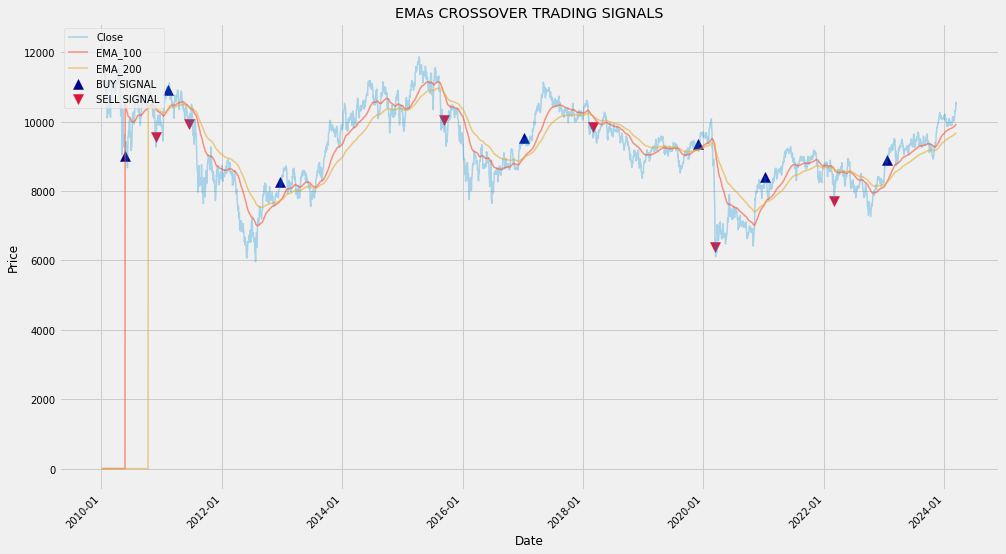

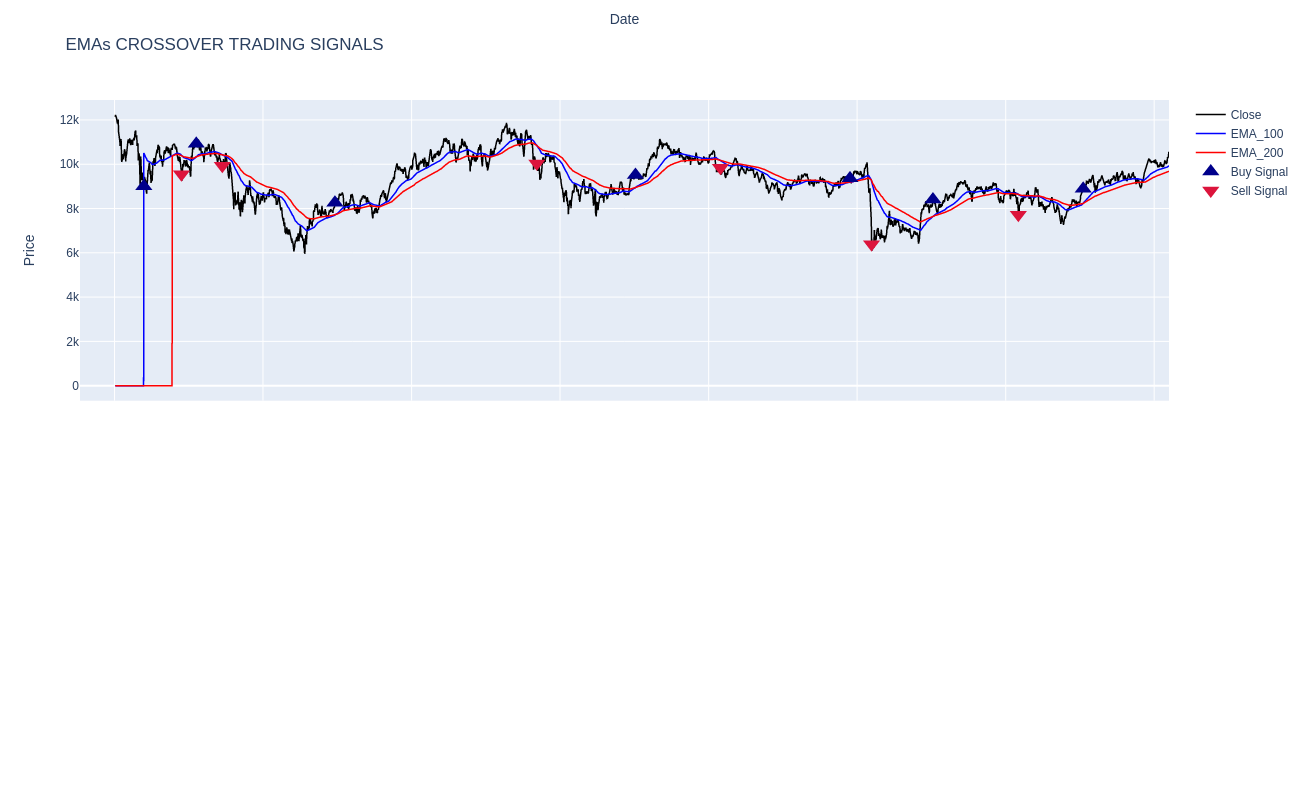

In [22]:
class EMAsStrategy():
    def __init__(self, indicators, short_window, long_window):
        self.indicators = indicators
        self.short_window = short_window
        self.long_window = long_window
        
    def detect_entry_exit_points(self):
        self.short_window_label = 'EMA_' + str(self.short_window)
        self.long_window_label = 'EMA_' + str(self.long_window)
        
        short_ema_df = self.indicators.exponential_moving_average(self.short_window)
        long_ema_df = self.indicators.exponential_moving_average(self.long_window)
        
        self.emas_df = self.indicators.close_df.join(short_ema_df).join(long_ema_df)
        
        self.entry_exit_dates = pd.DataFrame(index=self.emas_df.index, columns=['Close', 'Entry_Exit'])
        self.emas_df.fillna(0, inplace=True)
    
        position = 0
        for i in range(1, len(self.emas_df)):
            if self.emas_df[self.short_window_label][i] > self.emas_df[self.long_window_label][i] and self.emas_df[self.short_window_label][i - 1] <= self.emas_df[self.long_window_label][i - 1]:
                self.entry_exit_dates.loc[self.emas_df.index[i], 'Close'] = self.emas_df['Close'][i]  # Asignar el valor de Close
                self.entry_exit_dates.loc[self.emas_df.index[i], 'Entry_Exit'] = 1  # Compra
            elif self.emas_df[self.short_window_label][i] < self.emas_df[self.long_window_label][i] and self.emas_df[self.short_window_label][i - 1] >= self.emas_df[self.long_window_label][i - 1]:
                self.entry_exit_dates.loc[self.emas_df.index[i], 'Close'] = self.emas_df['Close'][i]  # Asignar el valor de Close
                self.entry_exit_dates.loc[self.emas_df.index[i], 'Entry_Exit'] = -1  # Venta
    
        self.entry_exit_dates.dropna(inplace=True)
        return self.entry_exit_dates
    
    def calculate_invest_evolution(self, entry_exit_dates):
        if len(self.entry_exit_dates) == 0:
            return self.entry_exit_dates  # Retornar el DataFrame vacío si no hay datos
        self.invest_evolution_df = self.entry_exit_dates .copy(deep=True)
        first_row = entry_exit_dates.iloc[0]
        self.invest_evolution_df ['Buy&Hold'] = 100.00 * (self.invest_evolution_df ['Close'] / first_row['Close'])
        cash = 100.00
        shares = 0
        for i, row in self.invest_evolution_df .iterrows():
            if row['Entry_Exit'] == 1:  # Compra
                shares = cash / row['Close']
                cash = 0
            elif row['Entry_Exit'] == -1:  # Venta
                cash = shares * row['Close']
                shares = 0
            self.invest_evolution_df.loc[i, 'Buy&Sell'] = cash + shares * row['Close']
        return self.invest_evolution_df

    def plot_buy_sell_signals_matplotlib(self): 
        self.short_ema_label = 'EMA_' + str(self.short_window)
        self.long_ema_label = 'EMA_' + str(self.long_window)        
        buy_prices = self.entry_exit_dates[self.entry_exit_dates['Entry_Exit'] == 1]
        sell_prices = self.entry_exit_dates[self.entry_exit_dates['Entry_Exit'] == -1]        
        
        plt.rcParams.update({'font.size': 10})
    
        plt.plot(self.emas_df['Close'], alpha=0.3, label='Close', lw=1.5)
        plt.plot(self.emas_df[ self.short_ema_label], alpha=0.6, label='EMA_' + str(self.short_window), lw=1.5)
        plt.plot(self.emas_df[self.long_ema_label], alpha=0.6, label='EMA_' + str(self.long_window), lw=1.5)
        
        plt.scatter(buy_prices.index, buy_prices['Close'], marker='^', s=100, color='darkblue', label='BUY SIGNAL')
        plt.scatter(sell_prices.index, sell_prices['Close'], marker='v', s=100, color='crimson', label='SELL SIGNAL')
    
        plt.legend(loc='upper left')
        plt.title('EMAs CROSSOVER TRADING SIGNALS')
        plt.xlabel('Date')
        plt.ylabel('Price')
    
        plt.xticks(rotation=45, ha='right')
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
        plt.show()

    def plot_buy_sell_signals_plotly(self):
        buy_prices = self.entry_exit_dates[self.entry_exit_dates['Entry_Exit'] == 1]
        sell_prices = self.entry_exit_dates[self.entry_exit_dates['Entry_Exit'] == -1]
    
        short_ema_label = 'EMA_' + str(self.short_window)
    
        fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.03)
    
        fig.add_trace(go.Scatter(x=self.emas_df.index, y=self.emas_df['Close'], mode='lines', name='Close', line=dict(color='black', width=1.5)), row=1, col=1)
        fig.add_trace(go.Scatter(x=self.emas_df.index, y=self.emas_df[short_ema_label], mode='lines', name=short_ema_label, line=dict(color='blue', width=1.5)), row=1, col=1)
        fig.add_trace(go.Scatter(x=self.emas_df.index, y=self.emas_df['EMA_' + str(self.long_window)], mode='lines', name='EMA_' + str(self.long_window), line=dict(color='red', width=1.5)), row=1, col=1)
    
        fig.add_trace(go.Scatter(x=buy_prices.index, y=buy_prices['Close'], mode='markers', name='Buy Signal', marker=dict(symbol='triangle-up', size=15, color='darkblue')), row=1, col=1)
        fig.add_trace(go.Scatter(x=sell_prices.index, y=sell_prices['Close'], mode='markers', name='Sell Signal', marker=dict(symbol='triangle-down', size=15, color='crimson')), row=1, col=1)
    
        fig.update_layout(title='EMAs CROSSOVER TRADING SIGNALS', xaxis=dict(title='Date', tickangle=45), yaxis=dict(title='Price'), height=800)
    
        fig.show()

# Parámetros de análisis
ticker = '^IBEX'
start_date = '2010-1-1'
end_date = '2024-3-15'
short_window = 100
long_window = 200

# Crear una instancia de TechnicalIndicators
indicators = CalculateEMAs(ticker, start_date, end_date, short_window, long_window)

# Llamar al método get_quotes() en la instancia creada
close_df, quote_closing_df = indicators.get_quotes()

emas = EMAsStrategy(indicators, short_window, long_window)

entry_exit_dates = emas.detect_entry_exit_points()
emas.calculate_invest_evolution(entry_exit_dates)
print (f'\nEvolución de la inversión:\n {emas.invest_evolution_df}\n')
emas.plot_buy_sell_signals_matplotlib()
emas.plot_buy_sell_signals_plotly()


# Nota de advertencias.
Este notebook tiene fines educativos y de demostración solamente. Las estrategias de inversión presentadas aquí son ejemplos y pueden contener errores. Se recomienda encarecidamente que cualquier decisión de inversión se tome después de consultar con un asesor financiero calificado. No se proporciona asesoramiento financiero, y cualquier uso de la información presentada es bajo su propio riesgo. Agradecemos cualquier retroalimentación para mejorar la calidad de estos ejemplos.  
Es importante recordar que no hay una estrategia única que funcione en todos los casos, y siempre hay un riesgo asociado con la inversión. Es recomendable realizar pruebas exhaustivas y análisis antes de implementar cualquier estrategia en un entorno de trading real.